In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-accidents/US_Accidents_March23.csv


In [2]:
df = pd.read_csv("/kaggle/input/us-accidents/US_Accidents_March23.csv", nrows=20000)
df = df[['ID', 'Severity', 'Start_Time', 'End_Time', 'Distance(mi)']]

Veri setimi df isimli değişkenimize atıyorum ancak bütün sütunları atamıyorum, sadece hesaplamalarımda kullanacağım sütunları ekleyerek hem ekstra iş yükünden hem de veri karmaşasından kurtuldum. Start_lat, End_lat gibi GPS kordinatlarıyla alakalı olan sütunları almadım.

In [24]:
df.info()
df.describe()
df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     20000 non-null  object        
 1   Source                 20000 non-null  object        
 2   Severity               20000 non-null  int64         
 3   Start_Time             20000 non-null  datetime64[ns]
 4   End_Time               20000 non-null  datetime64[ns]
 5   Start_Lat              20000 non-null  float64       
 6   Start_Lng              20000 non-null  float64       
 7   End_Lat                0 non-null      float64       
 8   End_Lng                0 non-null      float64       
 9   Distance(mi)           20000 non-null  float64       
 10  Description            20000 non-null  object        
 11  Street                 20000 non-null  object        
 12  City                   20000 non-null  object        
 13  C

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Duration
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,Night,Night,Night,Night,5.233333
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,Night,Night,Night,Day,0.500000
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,True,False,Night,Night,Day,Day,0.500000
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,Night,Day,Day,Day,0.500000
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,True,False,Day,Day,Day,Day,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,A-96,Source2,2,2016-02-11 07:28:16,2016-02-11 07:58:16,39.994061,-82.729416,NaN,NaN,0.01,...,False,False,False,False,False,Day,Day,Day,Day,0.500000
96,A-97,Source2,3,2016-02-11 07:29:06,2016-02-11 08:18:10,41.355396,-81.819267,NaN,NaN,0.01,...,False,False,False,False,False,Day,Day,Day,Day,0.817778
97,A-98,Source2,2,2016-02-11 07:53:55,2016-02-11 08:23:55,39.687389,-84.237968,NaN,NaN,0.00,...,False,False,False,False,False,Day,Day,Day,Day,0.500000
98,A-99,Source2,2,2016-02-11 08:07:02,2016-02-11 08:37:02,39.751038,-84.214325,NaN,NaN,0.01,...,False,False,False,False,False,Day,Day,Day,Day,0.500000


Buraya kadar olan kısımda veri setimiz ile alakalı EDA (Keşif Analizi) yaptım. Üstte de belirttiğim gibi veri setinin büyük bir kısmını almayıp sadece ihtiyacım olan kısımları aldığımdan çok fazla bir çıktı almamış olsam da, bu evrede edindiğim bilgilerle kafamda kazaların başlangıç ve bitiş zamanları arasındaki fark ile kazanın şiddetini (Severity) tahmin eden bir model kurguladım.

In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values='NaN', strategy='most_frequent')

Belirlediğim sütunlarda herhangi bir null, ?, NaN değer görmediğim halde yine de SimpleImputer kullanarak varolan bütün NaN değerleri o sütunda en sık bulunan değere eşitleyecek.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)

kNN modelimdeki n_neighbors parametresini 5 yapmamın sebebi açıkçası bu modelin Gözetimli Öğrenme tarafında çok verimli çalışacağını düşünmemem. Kaza süresinin kısa olup şiddetinin yüksek olduğu, kaza süresinin uzun olup şiddetinin düşük olduğu vakalar çok sayıda olduğundan, kNN modelinde ne kadar çok komşu bulundurursam sapmaların o kadar önüne geçebileceğimi düşündüm. Ne kadar doğru olup olmadığını şimdilik bilmiyorum.

In [8]:
steps = [('imputation', imputer), ('knn', knn_model)]

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df = df.dropna(subset=['Start_Time', 'End_Time'])

df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 3600

df = df.dropna(subset=['Duration'])

X = df[['Duration']].values
y = df['Severity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Modelin doğruluk oranı: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nKarışıklık Matrisi:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred, zero_division=0)
print("\nSınıflandırma Raporu:")
print(class_report)

Modelin doğruluk oranı: 0.57

Karışıklık Matrisi:
[[   0    1    0    0]
 [   0 1083   96    0]
 [   0  759   59    0]
 [   0    2    0    0]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.59      0.92      0.72      1179
           3       0.38      0.07      0.12       818
           4       0.00      0.00      0.00         2

    accuracy                           0.57      2000
   macro avg       0.24      0.25      0.21      2000
weighted avg       0.50      0.57      0.47      2000



Pipeline değişkenini oluşturduğum kısma kadar Göker hocanın anlattığı şekilde ilerledim. Ardından veri setindeki tarihlerin formatı 'Object' olduğundan bunları *pd.to_DateTime* fonksiyonu ile DateTime formatına çevirdim. Ardından kaza verilerinin bitiş ve başlangıç saatleri arasındaki farkı alarak 'df' değişkenine 'Duration' olarak ekledim. Tabii bu veriyi öncelikle 3600'e böldüm, bunun sebebi son sayının SAAT cinsinden olmasını istememdi. Sonuçta asıl amacım kazanın sürdüğü SAAT verisi ile kazanın ŞİDDETİNİ tahmin etmek.

Bunun ardından üstte de belirttiğim şekilde X ve y değişkenlerine gereken value'ları atadım. Ardından bunları kNN modeline oturttum ve y_pred değişkenime ilk değerimi X_test değişkenini kNN modeliyle çalıştırarak atadım. *sklearn.metrics* kütüphanesinden getirdiğim accuracy_score fonksiyonu ile de sonucu ekrana bastırdım.

confusion_matrix ve classification_report kısmında ChatGPT'den yardım aldığımı itiraf etmem gerekiyor. Sonuçları tam olarak nasıl bastıracağımı anlamamıştım, bu sebeple en kaba şekilde böyle bir matris bastırmayı uygun gördüm. Alt kısımda görsel olarak da çıktıyı görebilirsiniz. %57 gibi düşük bir sonuç beklemiyordum ancak sebebini de tam olarak anlamış değilim, yorumu size bırakıyorum.

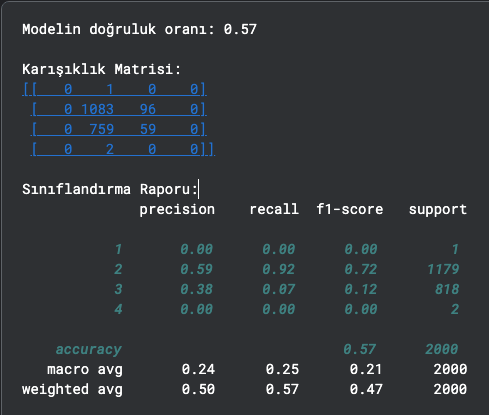

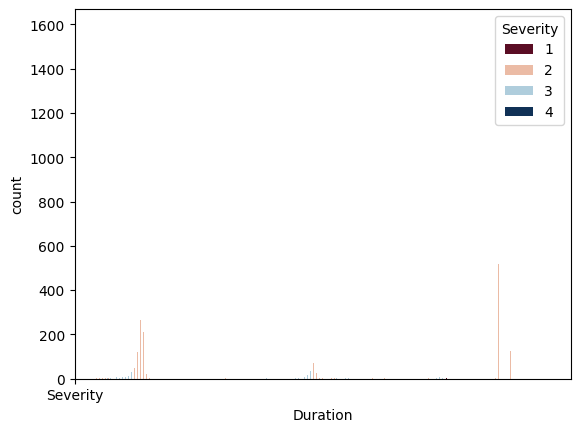

In [31]:
plt.figure()
sns.countplot(x='Duration', hue='Severity', data=df, palette='RdBu')
plt.xticks([1], ['Severity'])
plt.show()

Grafiği nasıl çizdireceğimi bilemedim açıkçası. 'Duration' adını verdiğim sütunu 'df'e atamadan önce kendisinin ne olduğunu belirlemem gerektiği için bu grafik işini ilk tahminlemeden sonrasına bıraktım. Görselleştirme kısmında zayıf kaldığımın farkındayım ancak bu konuyu pek kavrayamadım. Projeyi hiç göndermemiş olmaktansa bu kısmı affınıza bırakıyorum :( .

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

df = df.dropna(subset=['Duration'])

X = df[['Duration']].values
y = df['Severity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

decision_tree = DecisionTreeClassifier(random_state=42)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Karar Ağacı Modelinin Doğruluk Oranı: {accuracy:.4f}")

decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Hiperparametrelerle Karar Ağacı Modelinin Doğruluk Oranı: {accuracy:.4f}")

conf_matrix_tree = confusion_matrix(y_test, y_pred)
print("\nKarar Ağacı Karışıklık Matrisi:")
print(conf_matrix_tree)

class_report_tree = classification_report(y_test, y_pred, zero_division=0)
print("\nKarar Ağacı Sınıflandırma Raporu:")
print(class_report_tree)

Karar Ağacı Modelinin Doğruluk Oranı: 0.5840
Hiperparametrelerle Karar Ağacı Modelinin Doğruluk Oranı: 0.5972

Karar Ağacı Karışıklık Matrisi:
[[   0    2    0    0]
 [   0 2375    9    0]
 [   0 1598   14    0]
 [   0    2    0    0]]

Karar Ağacı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.60      1.00      0.75      2384
           3       0.61      0.01      0.02      1612
           4       0.00      0.00      0.00         2

    accuracy                           0.60      4000
   macro avg       0.30      0.25      0.19      4000
weighted avg       0.60      0.60      0.45      4000



İkinci Gözetimli Öğrenme algoritması olarak ise Karar Ağacı algoritmasını kullanmaya karar verdim. Gerekli kütüphaneleri ekledikten sonra ilk olarak 'Duration' sütunundaki NaN değerleri tedbir amaçlı tekrardan sildim. Önceki seferde bunu bütün 'df' değişkeni için SimpleImputer kullanarak yapmıştım, şuan ise sadece 'Duration' sütununa farklı şekilde uyguluyorum. Neredeyse birebir işlemleri aynı şekilde uyguladım. Tek fark hiperparametre denen kısımları denemem oldu. Birebir aynı sonucu almamın sebebini anlayamadım açıkçası. Çıktı görselini aşağıya bırakıyorum.

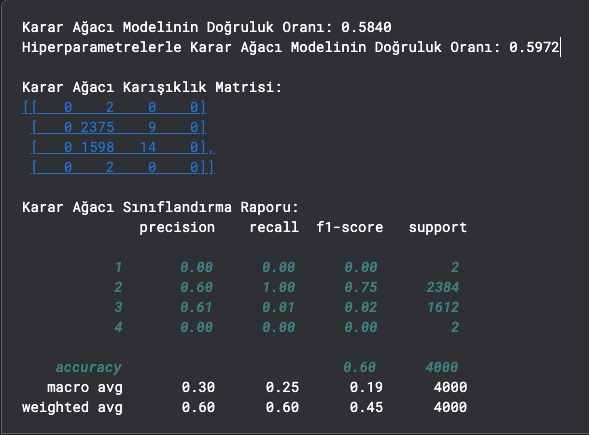

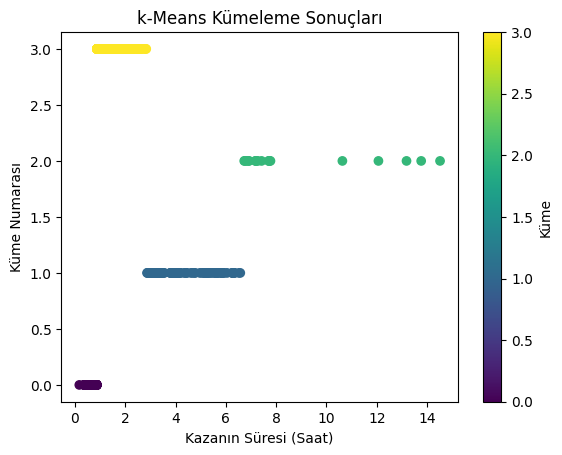


k-Means Karışıklık Matrisi:
[[    0     0     0     0     0]
 [   30     0     0     3     0]
 [10790    30     6  1452     0]
 [ 6743    58    13   866     0]
 [    9     0     0     0     0]]

k-Means Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        33
           3       0.32      0.00      0.00     12278
           4       0.37      0.11      0.17      7680
           5       0.00      0.00      0.00         9

    accuracy                           0.04     20000
   macro avg       0.14      0.02      0.03     20000
weighted avg       0.34      0.04      0.07     20000



In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

X = df[['Duration']].values

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], y_kmeans, c=y_kmeans, cmap='viridis')
plt.title('k-Means Kümeleme Sonuçları')
plt.xlabel('Kazanın Süresi (Saat)')
plt.ylabel('Küme Numarası')
plt.colorbar(label='Küme')
plt.show()

conf_matrix_kmeans = confusion_matrix(df['Severity'], y_kmeans)
print("\nk-Means Karışıklık Matrisi:")
print(conf_matrix_kmeans)

class_report_kmeans = classification_report(df['Severity'], y_kmeans, target_names=['1', '2', '3', '4', '5'], zero_division=0)
print("\nk-Means Sınıflandırma Raporu:")
print(class_report_kmeans)

Üstte de belirttiğim gibi grafik kısmını pek beceremedim ama önceki grafikten daha doğru olduğunu düşünüyorum. Açıkçası Gözetimsiz Öğrenme algoritmalarına çok fazla vakit ayıramadım, ancak yine de bu kadar kötü çalışmasını beklemiyordum. 0.04 gibi bir başarı oranım var, bunu verisetinin bu öğrenme türüyle verimli çalışmamasına ve kendimin gerekli işlemleri doğru sırayla yapmadığıma bağlıyorum.

Ayrıca eklemek istediğim ve zamanım kalmadığından size soramadığım bir soru, bu kısımda eğer target_names parametresini benim Severity sütunumda 4 veri olmasına rağmen 5 veri girmemi istemesiydi. Hala bir anlam verebilmiş değilim, ancak sürekli olarak aldığım hatanın ancak bu şekilde önüne geçebildim.  Aşağıya çıktı görselini bırakıyorum.

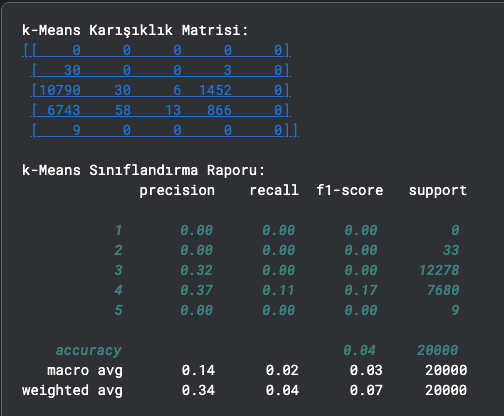

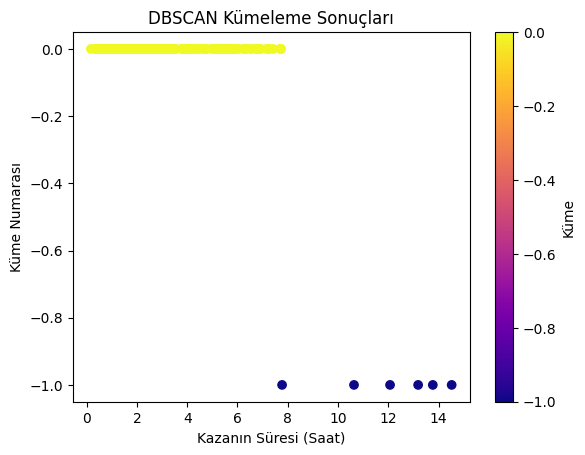


DBSCAN Karışıklık Matrisi:
[[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0    33     0     0     0     0]
 [    2 12276     0     0     0     0]
 [    4  7676     0     0     0     0]
 [    0     9     0     0     0     0]]

DBSCAN Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00      33.0
           4       0.00      0.00      0.00   12278.0
           5       0.00      0.00      0.00    7680.0
           6       0.00      0.00      0.00       9.0

    accuracy                           0.00   20000.0
   macro avg       0.00      0.00      0.00   20000.0
weighted avg       0.00      0.00      0.00   20000.0



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_

In [33]:
from sklearn.cluster import DBSCAN

# DBSCAN modeli
dbscan = DBSCAN(eps=0.5, min_samples=10)
y_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:, 0], y_dbscan, c=y_dbscan, cmap='plasma')
plt.title('DBSCAN Kümeleme Sonuçları')
plt.xlabel('Kazanın Süresi (Saat)')
plt.ylabel('Küme Numarası')
plt.colorbar(label='Küme')
plt.show()

conf_matrix_dbscan = confusion_matrix(df['Severity'], y_dbscan)
print("\nDBSCAN Karışıklık Matrisi:")
print(conf_matrix_dbscan)

class_report_dbscan = classification_report(df['Severity'], y_dbscan, target_names=['1', '2', '3', '4', '5', '6'])
print("\nDBSCAN Sınıflandırma Raporu:")
print(class_report_dbscan)

In [34]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

X = df[['Duration']].values

minibatch_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=100)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(X)

real_labels = df['Severity'].values

if np.sum(minibatch_kmeans_labels == real_labels) < np.sum(minibatch_kmeans_labels != real_labels):
    minibatch_kmeans_labels = 1 - minibatch_kmeans_labels

print("\nMini Batch k-Means Kümeleme Sonuçları")
print("------------------------------------")

accuracy_minibatch_kmeans = accuracy_score(real_labels, minibatch_kmeans_labels)
print(f"Mini Batch k-Means Doğruluk Skoru: {accuracy_minibatch_kmeans:.4f}")

conf_matrix_minibatch_kmeans = confusion_matrix(real_labels, minibatch_kmeans_labels)
print("\nMini Batch k-Means Karışıklık Matrisi:")
print(conf_matrix_minibatch_kmeans)

class_report_minibatch_kmeans = classification_report(real_labels, minibatch_kmeans_labels, target_names=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
print("\nMini Batch k-Means Sınıflandırma Raporu:")
print(class_report_minibatch_kmeans)


Mini Batch k-Means Kümeleme Sonuçları
------------------------------------
Mini Batch k-Means Doğruluk Skoru: 0.0003

Mini Batch k-Means Karışıklık Matrisi:
[[   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    1   25    7    0    0    0]
 [  47  231 8053 3947    0    0    0]
 [  76  181 5109 2314    0    0    0]
 [   0    0    7    2    0    0    0]]


ValueError: Number of classes, 7, does not match size of target_names, 4. Try specifying the labels parameter

Burada da aynı şekilde çıktı küme ihtimalim yani 'Severity' sadece 1-2-3-4 olabilecekken, öncekinin aksine class_report_minibatch_kmeans parametresi olarak 7 adet küme elemanı girmemi istiyor. Ayrıca doğruluk skorum da önceki Gözetimsiz Öğrenme algoritmamda olduğu gibi absürd derecede düşük. Veri setimin Gözetimsiz Öğrenmeye uygun olmadığını kanıtlar nitelikte. Mini Batch k-Means algoritmasının çıktı görselini de aşağıya bırakıyorum.

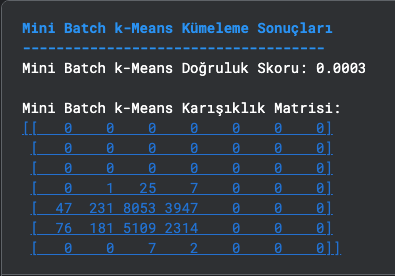